# Его величество, "домашка №1"

В этой домашней работе вам предоставится уникальная возможность обучить Byte-level BPE токенизатор и небольшую LM.  

Домашняя работа состоит из нескольких последовательных блоков: реализация и обучение токенизатора, реализация Transformer модели и обучение модели на датасете с русскими анекдотами!

Обученные токенизатор и модель можно и нужно выложить на [🤗 HuggingFace](https://huggingface.co/). Зарегистрируйтесь там, подпишитесь на [deep vk](https://huggingface.co/deepvk) и создайте себе API токен.

Следуйте ячейкам тетрадки и заполняйте пропущенные ячейки. В конце тетрадки вы найдете задачи со звездочкой, чтобы получить максимальный балл!

In [ ]:
%pip install safetensors

In [ ]:
# Установим необходимые дополнительные библиотеки

%pip install --quiet datasets livelossplot

In [ ]:
%pip install --upgrade seleniumbase


In [1]:
# Необходимые импорты

import inspect
import json
import os
from collections import Counter
from dataclasses import dataclass
from functools import lru_cache, partial
from pathlib import Path

import regex as re
import torch
import torch.nn as nn
from datasets import load_dataset
from huggingface_hub import HfApi, PyTorchModelHubMixin, interpreter_login, snapshot_download
from huggingface_hub.utils import SoftTemporaryDirectory
from livelossplot import PlotLosses
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange

In [2]:
# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)


def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")

In [3]:
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



In [4]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw1"  # Или как вам хочется

print(f"Homework repository: '{REPO_NAME}'")

# И другие полезные вещи
SEED = 0xC0FFEE

Homework repository: 'bdvs/llm-course-hw1'


# Датасет

Первым делом загрузим данные: [🤗 IgorVolochay/russian_jokes](https://huggingface.co/datasets/IgorVolochay/russian_jokes)

И немного посмотрим на них 👀

In [5]:
dataset = load_dataset("IgorVolochay/russian_jokes")
print("\n===\n".join(dataset["train"]["text"][:3]))

- Зять, а ты знаешь, где найти того мужчину, который спас меня, когда я тонула?- Да, он уже приходил ко мне извиняться!
===
После проведения акции "К животным по-человечески" животные посовещались и решили провести акцию "К человеку по-скотски".
===
Штирлиц пришел домой и сразу завалился на боковую. Средняя от досады заплакала.


# Токенизатор [6 баллов]

В качестве токенизатора будем использоват Byte-level BPE.

Для этого:
1. Реализуем его обучения, нам необходимо построить словарь заданного размера и набор слияний по этому словарю
2. Обучим токенизатор на датасете
3. Реализуем инференс токенизатора: кодирование текста и декодирование токенов


In [6]:
# Подготовим холдауты
dataset = dataset["train"].train_test_split(test_size=0.1, seed=SEED)
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 135497
    })
    test: Dataset({
        features: ['text'],
        num_rows: 15056
    })
})

In [ ]:
# Всякие полезности

WHITESPACE_SPLITTER = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")


def bytes_to_unicode() -> dict[int, str]:
    """The original dictionary consists of 256 bytes and their corresponding Unicode characters.
    For example, chr(33) is '!'. However, not all bytes have a visually appealing representation,
    so such characters are skipped and replaced with the first available ones, i.e. shifted by 256.
    """
    initial_bytes = (
        list(range(ord("!"), ord("~") + 1)) + list(range(ord("¡"), ord("¬") + 1)) + list(range(ord("®"), ord("ÿ") + 1))
    )
    initial_chars = [chr(it) for it in initial_bytes]
    n = 0
    for byte in range(2**8):
        if byte not in initial_bytes:
            initial_bytes.append(byte)
            initial_chars.append(chr(2**8 + n))
            n += 1
    return dict(sorted(zip(initial_bytes, initial_chars)))

In [8]:
def merge(merge_pair, pair_frequences, words_by_tokens):
    new_token = ''.join(merge_pair)
    new_words_by_tokens = Counter()
    
    for word, freq in words_by_tokens.items():
        new_word = []
        i = 0
        while i < len(word):
            if i < len(word) - 1 and (word[i], word[i + 1]) == merge_pair:
                new_word.append(new_token)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_words_by_tokens[tuple(new_word)] = freq
    
    pair_frequences = Counter()
    for word, freq in new_words_by_tokens.items():
        for i in range(len(word) - 1):
            pair_frequences[(word[i], word[i + 1])] += freq
    
    return pair_frequences, new_words_by_tokens

def train(data, vocab_size=1024, special_tokens=None):
    if vocab_size < 256:
        raise ValueError("Vocab size can't be less than 256")
    if special_tokens is None:
        special_tokens = []
    
    id2token = bytes_to_unicode()  
    merges = []
    
    words_by_tokens = Counter()
    for sample in tqdm(data, desc="Loading data"):
        words = WHITESPACE_SPLITTER.findall(sample.strip())
        for word in words:
            words_by_tokens[tuple(word)] += 1
    
    pair_frequences = Counter()
    for word, freq in words_by_tokens.items():
        for i in range(len(word) - 1):
            pair_frequences[(word[i], word[i + 1])] += freq
    
    pbar = trange(vocab_size, desc="Building vocabulary", initial=len(id2token) + len(special_tokens))
    while len(id2token) < vocab_size - len(special_tokens):
        if not pair_frequences:
            print("Not enough data to fulfil vocabulary")
            break
        
        top_pair = max(pair_frequences, key=pair_frequences.get)
        new_token = ''.join(top_pair)
        del pair_frequences[top_pair]
        
        if new_token in id2token.values():
            continue
        
        id2token[len(id2token)] = new_token
        merges.append(top_pair)
        
        pair_frequences, words_by_tokens = merge(top_pair, pair_frequences, words_by_tokens)
        pbar.update()
    pbar.close()
    
    for special_token in special_tokens:
        id2token[len(id2token)] = special_token
    
    return {v: k for k, v in id2token.items()}, merges

In [9]:
# Обучаем токенизатор на тренировочных текстах
# Для нашей задачи хватит и небольшого словаря, но можете пробовать и большего размера обучить!

vocab, merges = train(dataset["train"]["text"], vocab_size = 2048, special_tokens=["[EOS]"])

Loading data:   0%|          | 0/135497 [00:00<?, ?it/s]

Building vocabulary:  13%|#2        | 257/2048 [00:00<?, ?it/s]

In [10]:
# Посмотрим на случайные токены

random_tokens = [512, 614, 768, 888, 1022]
unicode_to_bytes = {v: k for k, v in bytes_to_unicode().items()}
for token_id in random_tokens:
    token = [k for k, v in vocab.items() if v == token_id][0]
    raw_bytes = bytes([unicode_to_bytes[it] for it in token])
    print(f"Token #{token_id}: '{raw_bytes.decode('utf-8', errors='replace')}'")
# В UTF-8 изначально нет русских символов и из-за этого появляется ошибка, в дальнейшем на работу это не влияет

KeyError: 'ц'

In [11]:
class ByteLevelBPETokenizer:
    def __init__(self, vocab, merges, eos_token="[EOS]"):
        super().__init__()
        if eos_token not in vocab:
            raise ValueError("There is no EOS token in vocab")
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        self.token2id = vocab
        self.id2token = {v: k for k, v in self.token2id.items()}
        self.eos_token = eos_token
        self.eos_token_id = self.token2id[eos_token]
        
        self.merges = merges
        self.bpe_ranks = {pair: i for i, pair in enumerate(merges)}
    
    @lru_cache
    def bpe(self, word):
        word = tuple(word)
        pairs = [(word[i], word[i + 1]) for i in range(len(word) - 1)]
        while pairs:
            bigram = min(pairs, key=lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            new_word = []
            i = 0
            while i < len(word):
                if i < len(word) - 1 and (word[i], word[i + 1]) == bigram:
                    new_word.append(''.join(bigram))
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            word = tuple(new_word)
            pairs = [(word[i], word[i + 1]) for i in range(len(word) - 1)]
        return word
    
    def encode(self, text, add_eos_token=True):
        words = WHITESPACE_SPLITTER.findall(text)
        tokens = [token for word in words for token in self.bpe(word)]
        token_ids = [self.token2id[token] for token in tokens if token in self.token2id]
        if add_eos_token:
            token_ids.append(self.eos_token_id)
        return token_ids
    
    def decode(self, idx):
        tokens = [self.id2token[i] for i in idx if i in self.id2token]
        text = ''.join(tokens)
        return text
    
    
    def push_to_hub(self, repo_id, *, private=None, token=None):
        api = HfApi()
        repo_id = api.create_repo(repo_id=repo_id, token=token, private=private, exist_ok=True).repo_id

        # Push the files to the repo in a single commit
        with SoftTemporaryDirectory() as tmp:
            save_directory = Path(tmp) / repo_id
            save_directory.mkdir(parents=True)
            with open(save_directory / "vocabulary.json", "w") as f_out:
                print(json.dumps(self.token2id, indent=2), file=f_out)
            with open(save_directory / "merges.json", "w") as f_out:
                print(json.dumps({"merges": self.merges}), file=f_out)

            return api.upload_folder(repo_id=repo_id, folder_path=save_directory, token=token)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *, token=None, **model_kwargs):
        if not os.path.isdir(pretrained_model_name_or_path):
            storage_folder = snapshot_download(repo_id=pretrained_model_name_or_path, token=token)
        else:
            storage_folder = pretrained_model_name_or_path
        storage_folder = Path(storage_folder)
        with open(storage_folder / "vocabulary.json", "r") as f_in:
            vocab = json.load(f_in)
        with open(storage_folder / "merges.json", "r") as f_in:
            merges = [tuple(it) for it in json.load(f_in)["merges"]]
        return cls(vocab, merges, **model_kwargs)

In [51]:
# Инициализируем токенизатор


tokenizer = ByteLevelBPETokenizer(vocab, merges)

In [52]:
# Загружаем токенизатор на хаб

tokenizer.push_to_hub(REPO_NAME)

CommitInfo(commit_url='https://huggingface.co/bdvs/llm-course-hw1/commit/cd595a02dcc0b935b7e04d3d44630a8e97b64693', commit_message='Upload folder using huggingface_hub', commit_description='', oid='cd595a02dcc0b935b7e04d3d44630a8e97b64693', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bdvs/llm-course-hw1', endpoint='https://huggingface.co', repo_type='model', repo_id='bdvs/llm-course-hw1'), pr_revision=None, pr_num=None)

In [53]:
# Скачиваем токенизатор с хаба

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
# Смотрим на работу токенизатора

text = "Что было полгода назад? Помимо грандиозных событий, полгода назад были ещё семинары по линейной алгебре."
ids = tokenizer.encode(text)
print(ids)
reverse_text = [tokenizer.decode([it]) for it in ids]
print("|".join(reverse_text))
print(tokenizer.decode(ids))

[1307, 677, 691, 273, 298, 1696, 63, 411, 340, 332, 365, 758, 1799, 581, 353, 445, 337, 44, 691, 273, 298, 1696, 1268, 311, 1018, 291, 380, 267, 513, 906, 439, 1720, 951, 300, 46, 2047]
Что| было| пол|го|да| назад|?| По|ми|мо| г|ран|дио|ных| со|бы|ти|,| пол|го|да| назад| были| е| сем|на|ры| по| ли|ней|ной| ал|ге|ре|.|[EOS]
Что было полгода назад? Помимо грандионых событи, полгода назад были е семнары по линейной алгере.[EOS]


In [16]:
# Посчитаем немного статистики по токенизации, определимся с размером контекста у модели

lens = []
for text in tqdm(dataset["test"]["text"]):
    ids = tokenizer.encode(text)
    lens.append(len(ids))

print(f"Average token len per sample: {sum(lens) / len(lens):.2f}")
print(f"Minimum and maximum lens are: {min(lens)} and {max(lens)}")

  0%|          | 0/15056 [00:00<?, ?it/s]

Average token len per sample: 52.46
Minimum and maximum lens are: 1 and 2453


Должно получиться в среднем по 70 токенов на последовательность.
Контекста в 128 токенов будет вполне достаточно.

# Модель [10 баллов]

В качестве модели реализуем трансформер, в котором
1. В качестве позиционных эмбеддингов используется ALiBi
2. Механизм внимания использует GQA
3. В Feed-Forward блоке SwiGLU

In [17]:
# Для удобства заведем конфиг для модели


@dataclass
class TransformerConfig:
    n_layer: int
    n_head: int
    n_kv_head: int
    hidden_dim: int
    intermediate_dim: int
    dropout: float = 0.1
    vocab_size: int = 1024
    max_seq_len: int = 128


model_configs = {
    "nano": TransformerConfig(n_layer=3, n_head=4, n_kv_head=2, hidden_dim=96, intermediate_dim=256),
    "mini": TransformerConfig(n_layer=6, n_head=6, n_kv_head=3, hidden_dim=384, intermediate_dim=1024),
    "small": TransformerConfig(n_layer=12, n_head=12, n_kv_head=6, hidden_dim=768, intermediate_dim=2048),
}

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x: Tensor) -> Tensor:
        norm_x = x * torch.rsqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        return self.scale * norm_x

class CausalSelfAttention(nn.Module):
    def __init__(self, config):

        super().__init__()
        self.config = config
        assert self.config.hidden_dim % self.config.n_head == 0
        assert self.config.n_head % self.config.n_kv_head == 0
        self.head_dim = config.hidden_dim // config.n_head
        self.scale = self.head_dim**-0.5
        self.q_per_kv = config.n_head // config.n_kv_head

        self.q_proj = nn.Linear(config.hidden_dim, config.hidden_dim)
        self.kv_proj = nn.Linear(config.hidden_dim, 2 * config.n_kv_head * self.head_dim)
        self.out_proj = nn.Linear(config.hidden_dim, config.hidden_dim)

        self.attn_dropout = nn.Dropout(config.dropout)

        self.register_buffer("causal_mask", self._create_causal_mask(config.max_seq_len))
        self.register_buffer("alibi", self._build_alibi_bias(config.n_head))

    def _build_alibi_bias(self, num_heads: int) -> Tensor:
        slopes = torch.tensor([2**(-8 * i / num_heads) for i in range(num_heads)])
        return slopes.view(1, num_heads, 1, 1)

    def _create_causal_mask(self, max_seq_len: int) -> Tensor:
        mask = torch.tril(torch.ones(max_seq_len, max_seq_len))
        return mask.view(1, 1, max_seq_len, max_seq_len)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        batch_size, seq_len, _ = x.shape
        q = self.q_proj(x).view(batch_size, seq_len, self.config.n_head, self.head_dim).transpose(1, 2)
        kv = self.kv_proj(x).view(batch_size, seq_len, 2, self.config.n_kv_head, self.head_dim).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]
        k = k.repeat_interleave(self.q_per_kv, dim=1)  # приведение k, v к одной размерности
        v = v.repeat_interleave(self.q_per_kv, dim=1)
        
        attn_weights = (q @ k.transpose(-2, -1)) * self.scale + self.alibi
        attn_weights = attn_weights.masked_fill(self.causal_mask[:, :, :seq_len, :seq_len] == 0, float('-inf'))
        attn_probs = F.softmax(attn_weights, dim=-1)
        attn_probs = self.attn_dropout(attn_probs)

        output = (attn_probs @ v).transpose(1, 2).reshape(batch_size, seq_len, self.config.hidden_dim)
        return self.out_proj(output)

class SwiGLU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.fc1 = nn.Linear(config.hidden_dim, config.hidden_dim * 2)
        self.fc2 = nn.Linear(config.hidden_dim, config.hidden_dim)

    def forward(self, x: Tensor) -> Tensor:
        x1, x2 = self.fc1(x).chunk(2, dim=-1)
        return self.fc2(F.silu(x1) * x2)

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = RMSNorm(config.hidden_dim)
        self.res_dropout_1 = nn.Dropout(config.dropout)
        self.attn = CausalSelfAttention(config)

        self.ln_2 = RMSNorm(config.hidden_dim)
        self.res_dropout_2 = nn.Dropout(config.dropout)
        self.mlp = SwiGLU(config)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        x = x + self.res_dropout_1(self.attn(self.ln_1(x), attention_mask))
        x = x + self.res_dropout_2(self.mlp(self.ln_2(x)))
        return x

class TransformerForCausalLM(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config: TransformerConfig):
        
        super().__init__()
        self.vocab_size = config.vocab_size
        self.max_seq_len = config.max_seq_len
        self.n_layer = config.n_layer
        self.n_head = config.n_head
        self.hidden_dim = config.hidden_dim
        self.dropout = config.dropout

        self.token_emb = nn.Embedding(config.vocab_size, config.hidden_dim)
        self.emb_dropout = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_final = RMSNorm(config.hidden_dim)
        self.lm_head = nn.Linear(config.hidden_dim, config.vocab_size, bias=False)
        
        self.apply(self._init_weights)

        n_params = sum(p.numel() for p in self.parameters())
        print(f"Number of parameters: {n_params / 1e6:.2f}M")
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, RMSNorm):
            torch.nn.init.ones_(module.scale)

    def forward(self, input_ids: Tensor, attention_mask: Tensor = None) -> Tensor:
        x = self.token_emb(input_ids)
        x = self.emb_dropout(x)
        for layer in self.layers:
            x = layer(x, attention_mask)
        x = self.ln_final(x)
        return self.lm_head(x)

    @torch.inference_mode()
    def generate(
        self, idx: Tensor, max_new_tokens, eos_token_id, temperature=1.0, do_sample=False, top_k=None
        ) -> Tensor:
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.shape[1] <= self.max_seq_len else idx[:, -self.max_seq_len:]
            logits = self(idx_cond)

            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                top_values, _ = torch.topk(logits, top_k)
                mask = logits < top_values[:, -1, None]
                logits[mask] = float('-inf')

            probs = F.softmax(logits, dim=-1)

            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                idx_next = torch.argmax(probs, dim=-1, keepdim=True)

            idx = torch.cat((idx, idx_next), dim=1)
            if idx_next == eos_token_id:
                break
        return idx


# Train Loop [2 + 2 балла]

Настало время обучать модель.
Небольшую можно пробовать обучать локально, но лучше всего воспользоваться GPU, например, на Google Colab.

За реализацию 2 балла, и еще 2 балла - если модель научилась генерить анекдоты.

Не забудьте проверить, что вы загрузили нужные веса на HF и у проверяющего скачается нужная версия.

In [19]:
# Определим датасет и как заворачивать семплы в батч
# Разные тексты имеют разную длину, поэтому будет падить до самого длина семпла
# Так же заведем дополнительную маску, чтобы механизм внимания не учитывал падинги


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        texts = self.texts[idx]
        tokenized_sequence = self.tokenizer.encode(texts)
        return tokenized_sequence


def data_collator(
    tokenized_sequences: list[list[int]], pad_token_id: int, max_seq_len: int = None
) -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = len(tokenized_sequences)
    max_batch_seq_len = min(max_seq_len, max((len(it) for it in tokenized_sequences)))

    input_ids = torch.full((batch_size, max_batch_seq_len), pad_token_id)
    attention_mask = torch.zeros((batch_size, max_batch_seq_len))

    for i, tok_seq in enumerate(tokenized_sequences):
        cur_len = min(len(tok_seq), max_batch_seq_len)
        input_ids[i, :cur_len] = torch.tensor(tok_seq[:cur_len])
        attention_mask[i, :cur_len] = 1

    return input_ids, attention_mask


def create_dataloader(dataset, pad_token_id, max_seq_len, batch_size, is_train):
    collate_fn = partial(data_collator, pad_token_id=pad_token_id, max_seq_len=max_seq_len)
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, drop_last=is_train, collate_fn=collate_fn, pin_memory=True
    )


_d = TextDataset(["Привет!", "Как твои дела?", "Осталось совсем немного до конца"], tokenizer)
_dl = create_dataloader(_d, tokenizer.eos_token_id, max_seq_len=16, batch_size=2, is_train=False)

for i, batch in enumerate(_dl):
    print(f"Batch #{i}")
    input_ids, attn_mask = batch
    print(input_ids, attn_mask, sep="\n\n")

Batch #0
tensor([[ 944,  531,   33, 2047, 2047],
        [1250,  880,  626,   63, 2047]])

tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])
Batch #1
tensor([[ 367,  618, 1475, 1171,  477,  327,  686,  475, 2047]])

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [20]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    
    assert num_training_steps >= num_warmup_steps

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def cross_entropy_loss(input_ids: Tensor, attention_mask: Tensor, logits: Tensor) -> Tensor:
    
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()
    shift_mask = attention_mask[:, 1:].contiguous()
    
    loss_fct = nn.CrossEntropyLoss(reduction="none")
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    loss = loss.view(shift_labels.size())
    loss = loss * shift_mask
    return loss.sum() / shift_mask.sum()


In [21]:
# Определим тренера с наиболее важными гиперпараметрами для обучения


class Trainer:

    def __init__(
        self,
        learning_rate=3e-4,
        weight_decay=0.01,
        clip_grad_norm=1.0,
        n_steps=10_000,
        val_every_n_steps=1_000,
        plot_every_n_steps=100,
    ):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.clip_grad_norm = clip_grad_norm
        self.n_steps = n_steps
        self.val_every_n_steps = val_every_n_steps
        self.plot_every_n_steps = plot_every_n_steps

        if torch.cuda.is_available():
            self.device = "cuda"
        elif torch.backends.mps.is_available():
            self.device = "mps"
        else:
            self.device = "cpu"
        print("running on device", self.device)

    @torch.no_grad()
    def validate(self, model, val_loader):
        model.eval()
        val_loss = 0.0
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            val_loss += cross_entropy_loss(input_ids, attention_mask, logits)
        return val_loss / len(val_loader)

    def run(self, model, train_loader, val_loader):
        model = model.to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=0.1 * self.n_steps, num_training_steps=self.n_steps
        )
        model.train()

        plotlosses = PlotLosses(figsize=(15, 9), step_names="Step")
        logs = {"lr": 0, "epoch": 0}

        data_iter = iter(train_loader)
        for iter_num in range(self.n_steps):
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                logs["epoch"] += 1
                batch = next(data_iter)

            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            loss = cross_entropy_loss(input_ids, attention_mask, logits)

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip_grad_norm)
            optimizer.step()
            scheduler.step()

            if iter_num > 0 and iter_num % self.val_every_n_steps == 0:
                val_loss = self.validate(model, val_loader)
                plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
                plotlosses.send()
                model.train()

            if iter_num % self.plot_every_n_steps == 0:
                logs["loss"] = loss.item()
                logs["lr"] = scheduler.get_last_lr()[0]
                plotlosses.update(logs, current_step=iter_num)
                plotlosses.send()

        val_loss = self.validate(model, val_loader)
        plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
        plotlosses.send()

In [22]:
# Создаем тренировочный и тестовые даталоадеры


MAX_SEQ_LEN = 128
BATCH_SIZE = 16

train_dataset = TextDataset(dataset["train"]["text"], tokenizer)
train_dataloader = create_dataloader(
    train_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=True
)

test_dataset = TextDataset(dataset["test"]["text"], tokenizer)
test_dataloader = create_dataloader(
    test_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=False
)

In [62]:
# Инициализируем модель

config = model_configs["mini"]
model = TransformerForCausalLM(config)

Number of parameters: 6.11M


In [63]:
# Инициализируем тренера

trainer = Trainer(learning_rate=3e-4, weight_decay=0.02, clip_grad_norm=1.0, n_steps=10_000, val_every_n_steps=1_000, plot_every_n_steps=100)

running on device mps


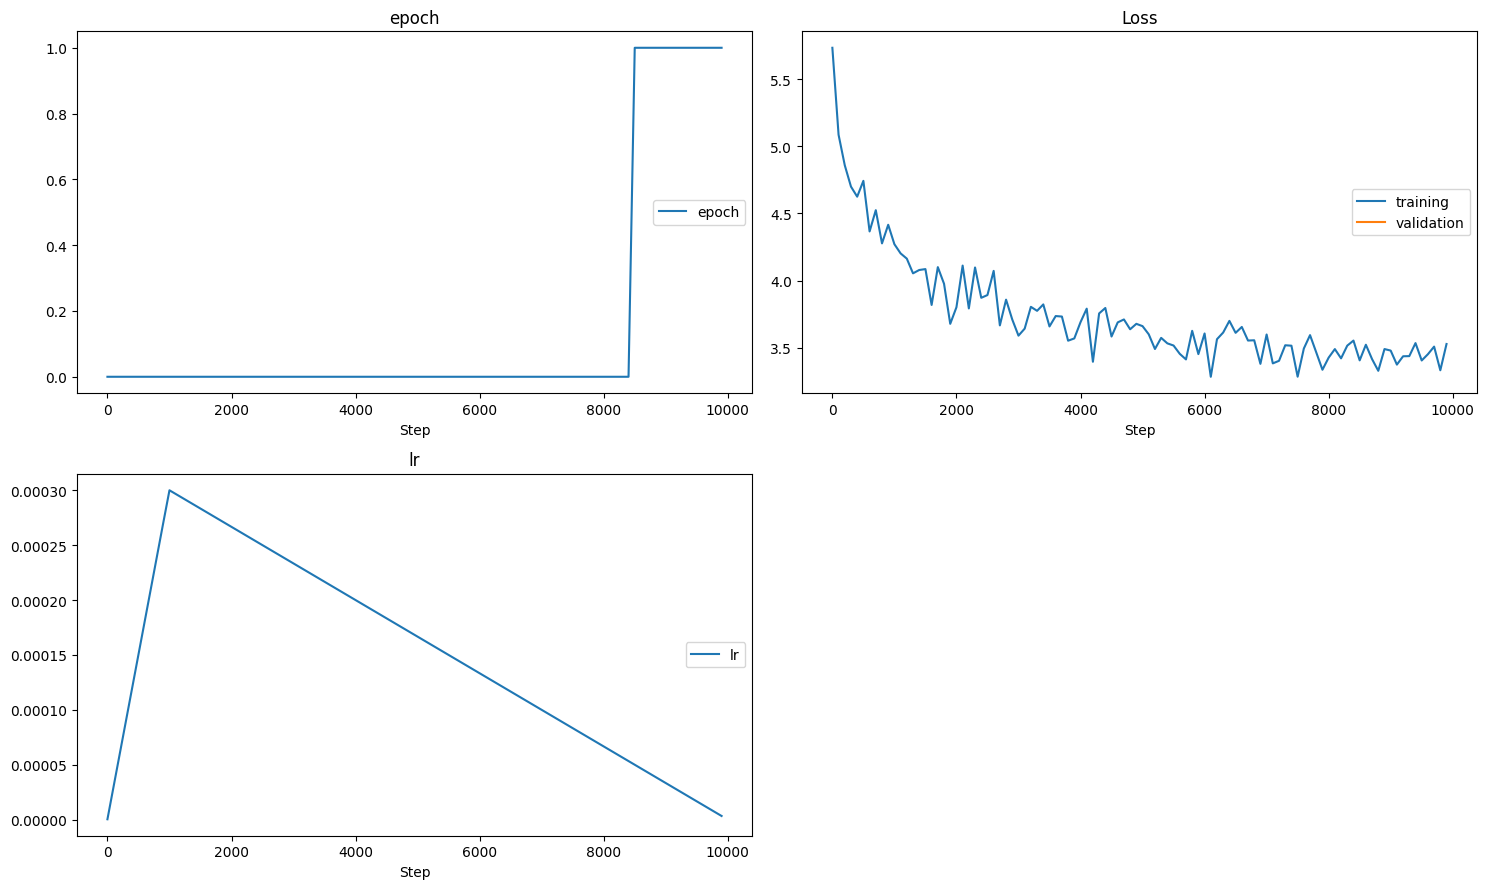

epoch
	epoch            	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    3.284, max:    5.733, cur:    3.528)
	validation       	 (min:      nan, max:      nan, cur:      nan)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)


In [64]:
# Обучение goes brrrr!

trainer.run(model, train_dataloader, test_dataloader)

In [65]:
# Смотрим на качество генерации глазами
# Для маленьких и слабых моделей "затягиваем" гайки генерации

text = "Заходит в бар"
input_ids = torch.tensor(tokenizer.encode(text)[:-1], device=trainer.device)[None, :]
print(input_ids)
model_output = model.generate(
    input_ids, max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True, top_k=50, temperature=0.6
)
tokenizer.decode(model_output[0].tolist())

tensor([[ 970,  499,  257, 2013]], device='mps:0')


'Заходит в бартеку и спрашивает: - С чего это такое у вас, если отрабатываясь? - Да, что, вы не было иметите, что вы бы вы знали, что если бы вы не задали - нашей жизни не будет. - А вы, как? - А если бы он не в твоем? - Да, что бы не професси? - А в это задницу. - А то я и говорит, что за что у вас уже есть, то, но и на него не то вспокоить. - У меня, что она еще и женился, что такое же он урами. - Понимание... - Еще не надо. - А, но я бы же, что я бы, не сгонялся. - Да вот, а вы настояще бы не у тебя... - это было бывает. - Это ты оно. - Идинарезаешь!'

In [66]:
# Загружаем модель на хаб

model.push_to_hub(REPO_NAME)

model.safetensors:   0%|          | 0.00/24.9M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bdvs/llm-course-hw1/commit/cc561d0547e399f1e3f587a8c2bd045ac7b2362a', commit_message='Push model using huggingface_hub.', commit_description='', oid='cc561d0547e399f1e3f587a8c2bd045ac7b2362a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bdvs/llm-course-hw1', endpoint='https://huggingface.co', repo_type='model', repo_id='bdvs/llm-course-hw1'), pr_revision=None, pr_num=None)

Поиграйтесь с гиперпараметрами, попробуйте обучить `mini` и `small` версии.
Постарайтесь добиться как можно более высокого качества как в терминах лосса, так и при визуальной оценке генерации.

### Дополнительные баллы

Вы также можно заработать дополнительные баллы:
- Реализовать Rotary Positional Embedding **[4 балла]**
- Реализовать Multi-Head Latent Attention **[2 балл]**
- Оформить репозиторий на 🤗: карточка модели с описанием задания, репортом качества и примерами генерации **[2 балл]**

# Специальный раздел для проверяющего

In [67]:
device = torch.device("mps")

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)
check_model = TransformerForCausalLM.from_pretrained(REPO_NAME)
check_model = check_model.to(device)
check_model = check_model.eval()

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/24.9M [00:00<?, ?B/s]

Number of parameters: 6.11M


In [68]:
text = "Штирлиц пришел домой"
input_ids = torch.tensor(tokenizer.encode(text), device=device)
model_output = check_model.generate(
    input_ids[None, :], max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())

'тирлиц пришел домой[EOS] в камерку и говорит:- Ты, как делаешь, что я с вами не смывал?- Нет, не вижу.- Это я - это не вспонишь, что я тебя напорилась. Поня, а ты что, находился. Надодиответ, что она меня и показала?- Нет, что он мне в ро, аду. И не заглядит на тебя. Идет. А если у меня на меня на тебя в говно нали. И тут же настояще нашел в попуке, а я - не вспонизу. Я и на тебя. Ну, а не заторила. И вот, то я бы вы не внусь! Я не на меня идился. Я не находи, как бы выраста, иди внулась, я быстре и я тебя, а потом у тебя захочу. Вот я, но'